In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy as sp
import time

In [2]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
EOS_files = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"
NICER_data = "/home/tplohr/proj/SF 24-25/data/J0437.dat"

def loadfile(number, pathprefix):
    file = open(pathprefix + str(number) + '.dat', 'r')
    return file

In [3]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadfile(i+1, EOS_files), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["radius"], df["mass"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of radius values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][0][j] is the radius value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i

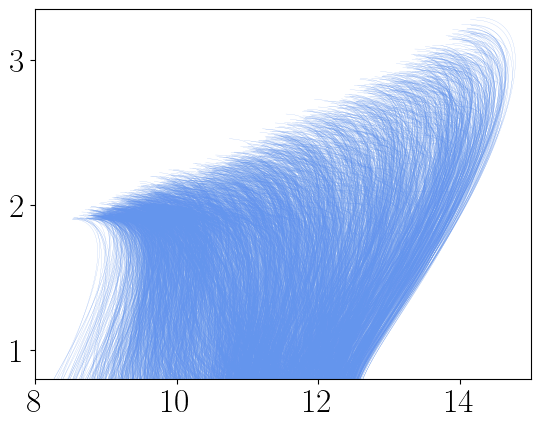

In [4]:
#plots each EOS 
for i in range(numofEOS):
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.rcParams['figure.figsize'] = [8,3]
    plt.plot(EOSs[i][0], EOSs[i][1], 'cornflowerblue', linewidth=.1)

In [5]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.ones(numofEOS)/numofEOS

In [6]:
#reading in the data from NICER
dataframe = pd.read_csv(NICER_data, delim_whitespace=True, header=None)
selected_columns = dataframe.iloc[:,[0,1]]
data = selected_columns.to_numpy()[:10000]
print(np.shape(data))
#using a KDE to get the probability density function for the likelihood
pdf = sp.stats.gaussian_kde((data[:,1], data[:,0]))

(10000, 2)


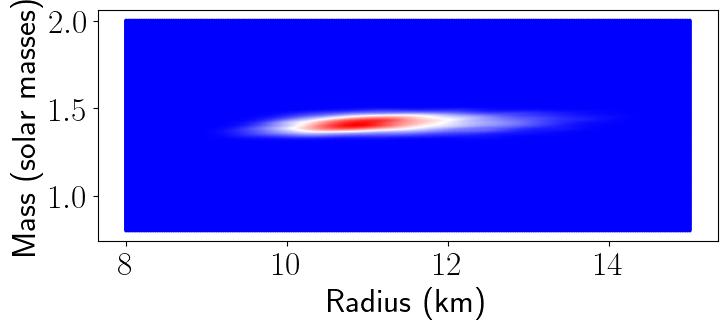

In [7]:
#plotting the pdf 
X = np.linspace(8, 15, 250)
Y = np.linspace(0.8, 2.0, 250)
points = np.zeros((250*250, 2))
prob=np.zeros(250*250)
for i in range(250):
    for j in range(250):
        points[i+j*250] = [X[i], Y[j]]
        prob[i+j*250] = pdf.evaluate((X[i], Y[j]))
#normalize the probabilities so the highest is always the same shade of red
norm = plt.Normalize(prob.min(), prob.max())
cmap = mp.colors.LinearSegmentedColormap.from_list("blue_white_red", ["blue", "white","red"])
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
plt.scatter(points[:,0], points[:,1], color=cmap(norm(prob)), s=3)

In [8]:
#calculate the probability of the observations given an EOS; likelihood
num_points = 1000
def calc_P_obs_given_EOS(i):
    #m is the interpolated function m(r)
    m = sp.interpolate.interp1d(EOSs[i][0], EOSs[i][1])
    
    #various radius related values for calculated the derivative of m(r) (m_prime)
    min_r = np.min(EOSs[i][0])
    max_r = np.max(EOSs[i][0])
    len_r = max_r-min_r
    #important to note that num_points is set, not delta_r
    delta_r = len_r/(num_points-1)
    #r is an array of all the radius values to sum over
    r = np.linspace(min_r, max_r, num_points)
    
    P = 0
    #loop over each radius value space by delta_r
    for j in range(num_points):
        #probability of the mass-radius point
        pdf_value = pdf.evaluate((r[j], m(r[j])))
        
        #probability of EOS_i is the sum of the probability of each point multiplied by the distance to the next point
        P += pdf_value*delta_r
    return P

In [9]:
start=time.time()
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = calc_P_obs_given_EOS(i)
    #calculate the denominator (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

for i in range(numofEOS):
    #calculate the posterior
    P_EOS_given_obs[i] = P_obs_given_EOS[i] / norm_factor
end=time.time()
print(end-start)

1520.652529001236


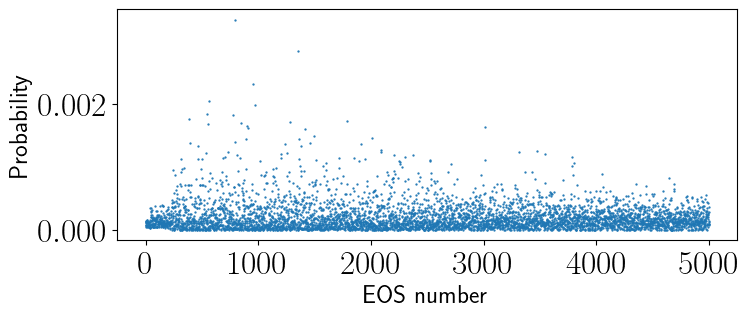

In [10]:
plt.xlabel("EOS number", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)

In [11]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

0.9999999999999959


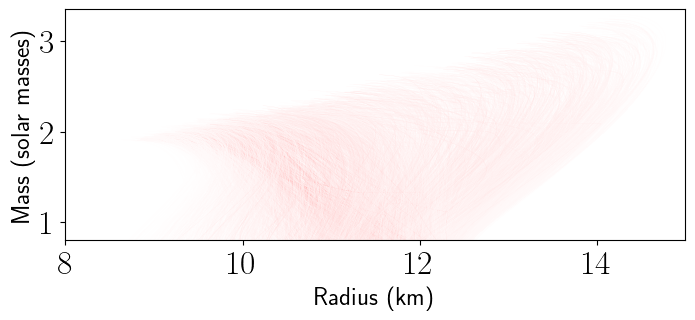

In [12]:
#plotting each EOS; low probability is white, high probability is red
cmap = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
for i in range(numofEOS):
    color = cmap(norm(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.rcParams['figure.figsize'] = [9,5]
    plt.plot(EOSs[i][0], EOSs[i][1], color=color, linewidth=.1)